<a href="https://colab.research.google.com/github/erika-hornecker/Astrostats-HW2/blob/main/ACT_DR6_detector_cuts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector Cuts for ACT Data Processing: A Simplified Example

Written by Yilun Guan and the ACT collaboration

**Understanding and removing noise and artifacts from raw data is a crucial step in Cosmic Microwave Background (CMB) data analysis.**  Experiments like the Atacama Cosmology Telescope (ACT) collect vast amounts of data which, while containing the faint CMB signal, is also contaminated by various sources of noise, instrumental effects, and atmospheric interference.  **"Detector cuts"** are a set of procedures designed to identify and remove these contaminated detectors, ensuring the highest quality CMB maps and accurate cosmological parameter estimation.

This notebook provides a **practical introduction to the detector cut pipeline employed in ACT data processing.** It's a simplified, "light version" focusing on the core concepts and techniques. We will use a sample Time-Ordered Data (TOD) file to walk through the key steps involved in identifying and flagging problematic detectors and data samples.

For a more comprehensive and theoretical understanding of the data cuts pipeline used in ACT Data Release 6 (DR6), please refer to Naess et al. (2025). This notebook aims to complement that paper by providing a hands-on, code-driven exploration of the core concepts.

Let's begin by installing the necessary software...

## Install a light version of the TOD processing package.

First, we need to install numpy<2 for dependency compatibility. But colab comes shipped with numpy 2. To get around this, we install numpy<2, but then you MUST click 'Runtime -> Restart Session' before proceeding. We add an assert statement to make sure this succeeded.

In [ ]:
!pip install 'numpy<2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 478.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
import numpy as np
assert np.__version__[0] == '1', f'need numpy 1, got numpy {np.__version__[0]}'

This line installs the `moby2_light` Python package, a simplified version of the full `moby2` software suite developed for CMB data analysis. `moby2_light` contains pure python re-implementation of ACT data structure for working with ACT TODs, data cuts, etc. made specifically for this notebook to illustrate the core concepts. The full moby2 library can be found here: https://github.com/ACTCollaboration/moby2

In [ ]:
!pip install -U --force-reinstall git+https://github.com/guanyilun/moby2_light.git

  Cloning https://github.com/guanyilun/moby2_light.git to /tmp/pip-req-build-9bnjznhu
  Running command git clone --filter=blob:none --quiet https://github.com/guanyilun/moby2_light.git /tmp/pip-req-build-9bnjznhu
  Resolved https://github.com/guanyilun/moby2_light.git to commit 923a49f8d4837cc43fea36cc9219e2f231172eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 12.2 MB/s eta 0:00:00
  Created wheel for moby2: filename=moby2-0.1.0-py3-none-any.whl size=18839 sha256=fa82d64fb8126ca6e941c262d7c6bc498ffc124ec2a9c7c08c0b025995cfa002
  Stored in directory: /tmp/pip-ephem-whe

Setup necessary imports and data dependencies

In [ ]:
from matplotlib import pyplot as plt

import numpy as np

from moby2.tod import TOD, remove_mean, detrend_tod
from moby2.tod.cuts import *

%matplotlib inline


dir = '.'

## Introduction to TOD and Loading Data

ACT collects data in units of around 11 minutes. Each of these data files is called a **TOD**, which stands for **Time-Ordered Data**. First, we will load a TOD.

In [ ]:
tod_name = '1619094940.1619105593.ar5_f090'
!wget https://phy-act1.princeton.edu/public/data/dr6_tod_v1/nocal_1619094940.1619105593.ar5_f090.npz

--2025-03-24 05:40:14--  https://phy-act1.princeton.edu/public/data/dr6_tod_v1/nocal_1619094940.1619105593.ar5_f090.npz
Resolving phy-act1.princeton.edu (phy-act1.princeton.edu)... 128.112.102.238
Connecting to phy-act1.princeton.edu (phy-act1.princeton.edu)|128.112.102.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1832023829 (1.7G)
Saving to: ‘nocal_1619094940.1619105593.ar5_f090.npz’

nocal_1619094940.16 100%[===================>]   1.71G   171MB/s    in 16s     

2025-03-24 05:40:30 (109 MB/s) - ‘nocal_1619094940.1619105593.ar5_f090.npz’ saved [1832023829/1832023829]



Let's break down the components of this filename:

*   `1619094940.1619105593`:  These are the **starting and ending ctime (Unix timestamps)** of the data collection period.  ctime is a common way to represent points in time in computing.
*   `.ar5:f090`: This postfix indicates:
    *   `.ar5`:  The detector array that this data belongs to.
    *   `:f090`:  The frequency band – in this case, 90 GHz (f090).

To load a TOD, we use the `TOD.from_npz_forcutsdemo()` function (made for this demo) from the `moby2.tod` module:

In [ ]:
# this function will load a 6-minute TOD
tod = TOD.from_npz_forcutsdemo(dir, tod_name)

The actual detector data is stored in variable `tod.data` with shape `(num of detector, num of time samples)`. For example, to view the entire timestream collected by detector 1759, we can do the following:

In [ ]:
det_num = 1759

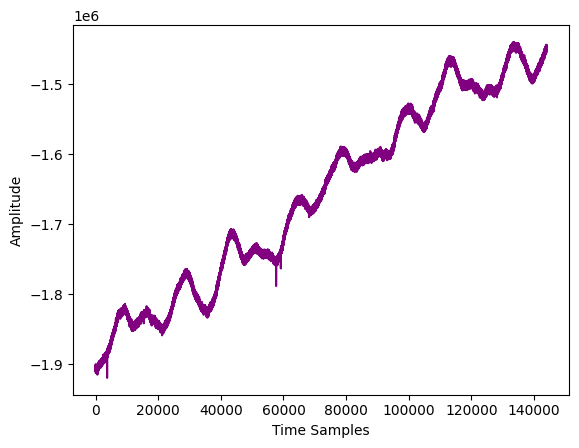

In [ ]:
plt.figure()
plt.plot(tod.data[det_num,:].T, color = 'purple')
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

First thing you will notice is the fluctuation in the timestream, which comes from atomosphere fluctuation for the most part. Also note the spikes appearing in the timestreams. Those are likely caused by cosmic rays hitting our detector or our read-out circuit having a glitch. In either case, we don't want to include those samples in the final CMB map, hence we need to **cut** these samples. Note that the glitch appeared flipped in the example above because the detectors are uncalibrated, this means the timestream may not have the right sign (different detectors have different optical signs in ACT!)

Another important failure mode is when a detector is malfunctioning. As a result, we want to flag the entire timestream of these faulty detectors and prevent them from getting into our CMB maps. To identify these detectors, we can perform a **multi-frequency analysis**.

The reason is that, **in frequency space, different systematic effects decouple nicely:**

*   **Low Frequency Part:** Fluctuations from the **atmosphere dominate** the low-frequency part of the data.
*   **High Frequency Part:** **Photon shot noise and detector white noise** are dominant in the high-frequency part of the data.

By analyzing the data in frequency space, we can distinguish between detectors that are responding correctly to the atmospheric signal and those that are showing unusual or problematic behavior across different frequency ranges.

**We will first go over the detector cuts** – the process of identifying and flagging entire detectors that are deemed faulty or unreliable – before moving on to other types of cuts like those for glitches.

# 1. Multi-frequency analysis (detector cuts)

Before performing FFT (Fast Fourier Transform), we first preprocess the data to remove the mean and slope. This is standard practice to prepare the data for frequency domain analysis.

In [ ]:
# transform data before taking fft
# remove the mean
remove_mean(tod)

# detrend
detrend_tod(tod)

# downsample
tod.data = tod.data[:, ::2]

*   **`remove_mean(tod)`:** This function subtracts the mean value from each detector's timestream. This centers the data around zero and removes any DC offset.
*   **`detrend_tod(tod)`:** This function removes linear trends (slopes) from each detector's timestream. These trends can be caused by slow drifts in the baseline signal.
*   **`tod.data = tod.data[:, ::2]`:** This line **downsamples** the data by a factor of 2. Downsampling reduces the data size and can be useful for focusing on lower frequencies relevant for detector cuts or for computational efficiency.

Next, we perform the FFT (Fast Fourier Transform):

In [ ]:
# fft
fdata = np.fft.rfft(tod.data)
freqs = np.fft.rfftfreq(tod.data.shape[-1], d=1/200)  # ar5 samples at 400 Hz, downsampled at 2

Now, let's look at the spectra of different detectors (over-plotted with alpha and plotting only every 10 detectors):

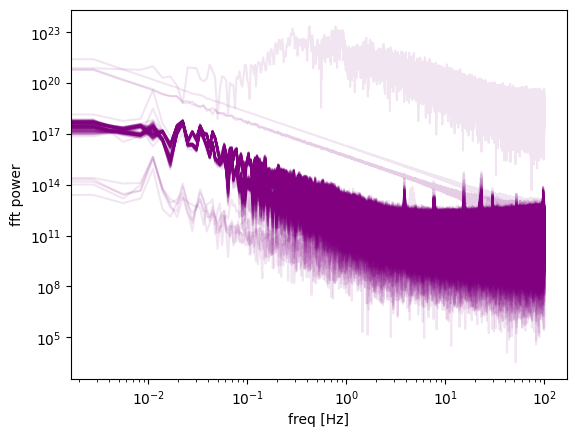

In [ ]:
# plot ps
ps = np.abs(fdata)**2
plt.figure()
plt.loglog(freqs, ps[::10,:].T, alpha=0.1, c="purple")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

**Interpreting the Power Spectra Plot:**

The plot shows the **power spectrum of the detector data in the frequency domain.** Let's analyze the key features:

*   **X-axis: freq [Hz] (logarithmic scale).** This shows the frequency range from very low frequencies (around 0.01 Hz) to higher frequencies (around 200 Hz, downsampled from 400 Hz). The logarithmic scale allows us to see features across a wide range of frequencies.
*   **Y-axis: fft power (logarithmic scale).** This shows the power spectral density, representing the amount of power at each frequency.  Higher values indicate more power at that frequency. Logarithmic scale is used to accommodate the large range of power values.

*   **1/f Noise at Low Frequencies:**  You can observe that at **lower frequencies (below approximately 1 Hz)**, the power spectra exhibit a **"dropping" behavior.** This is the characteristic signature of **1/f noise**. 1/f noise in ACT is primarily due to **atmosphere noise**.

*   **White Noise at High Frequencies:**  At **higher frequencies (above approximately 10 Hz)**, the power spectra become **"flat"**. This indicates **white noise**.

*   **Knee Frequency (fknee):** The **frequency where the spectrum transitions from 1/f noise to white noise** is often called the **knee frequency (fknee)**.  You can visually estimate the knee frequency from the plot as the point where the downward sloping 1/f noise part transitions to the flat white noise part.

*   **Common modes:**  You can see many detector spectra are similar, showing similar spectral characteristics and shapes. This is because most detectors see the same atmosphere.

ACT detector arrays are **"multi-chroic"**. This means they **observe at two different frequencies simultaneously** (in this case, 90 GHz and 150 GHz).

In [ ]:
np.unique(tod.info.array_data['nom_freq'])

array([  0.,  90., 150.])

This shows that our detectors are looking at 90 GHz and 150 GHz. (0 GHz is to denote detectors that are not connected. )

We can then isolate detectors from 90GHz only.

In [ ]:
detsf90 = np.where(tod.info.array_data['nom_freq'] == 90)[0]

print(f"{len(detsf90)} detectors are observing at 90GHz \
out of the total {len(tod.info.array_data['nom_freq'])} detectors")

858 detectors are observing at 90GHz out of the total 1760 detectors


Replot our fft power spectrum with the 90GHz detectors

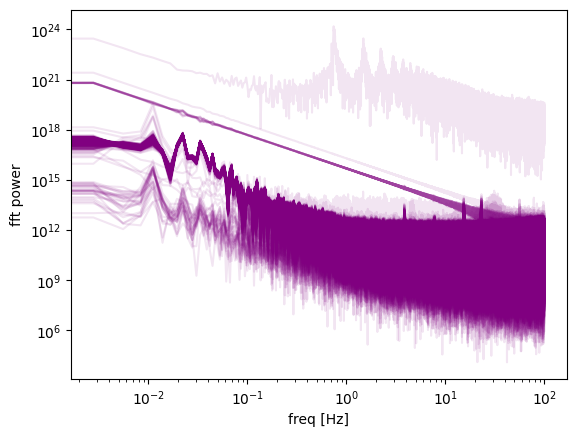

In [ ]:
# plot ps
plt.figure()
plt.loglog(freqs, ps[detsf90,:].T, alpha=0.1, c="purple")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

There are many faint lines with very weird shapes. They are likely some systematic contaminated detectors. As they don't follow the atmospheric signal, we can't trust that they can see the CMB so we will need to flag them to prevent them from being used in making CMB maps, which is crucial!

## Low-frequency


The objective in the low frequency analysis is to identify the group of detectors that are seeing the same atmosphere, which means they are behaving properly. In other words, good detectors should see the atmosphere as a common mode signal. We can thus make use of **common-mode analysis** to identify these detectors. To find the common mode and each detector's amplitude / response to the common mode signal, we can perform a **Singular-Value-Decomposition (SVD)** of our detector power spectrum at low frequencies, which is what we will do next.

First, let's focus on frequencies below 0.2 Hz, as this is the frequency range where atmospheric noise is expected to be dominant.

In [ ]:
fmask = freqs < 0.2

We will restrict our attention to the 90GHz detectors we isolated earlier and to the frequencies below 0.2 Hz in which atmosphere is dominating.

In [ ]:
lf_data = fdata[np.ix_(detsf90,fmask)]
lf_data.shape

(858, 72)

Then we use SVD to decompose our TOD, denoted as `d(ndets,nsamps)`, as
$$ d = USV^T$$
with `U[ndets, nmodes]`, `S[nmodes, nmodes]`, and `V^T[nmodes, nsamps]`.

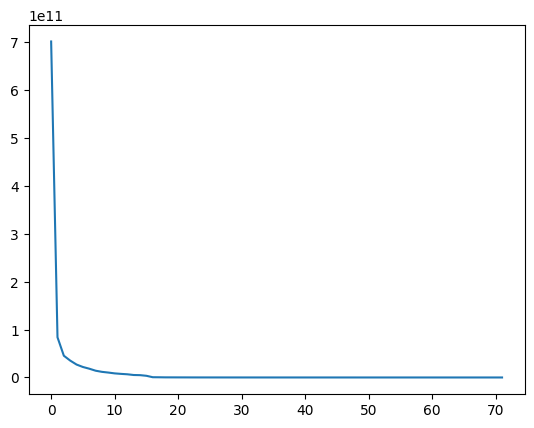

In [ ]:
u, s, v = np.linalg.svd(lf_data, full_matrices=False)

plt.plot(s)

The number in S matrix roughly corresponds to the amount of variance explained by each common mode. We can see that the first common mode is has then highest the variance. This is likely the atmospheric signal as we expect it to dominate the common mode in this frequency.

How well each detector is responding to a common mode `i` is given by `u[:,i]`. The amplitude to the atmosphere common mode is often denoted as `gain` in ACT.

In [ ]:
gain = np.abs(np.real(u[:,0]))
# we only care about the relative efficiency
gain /= np.median(gain)

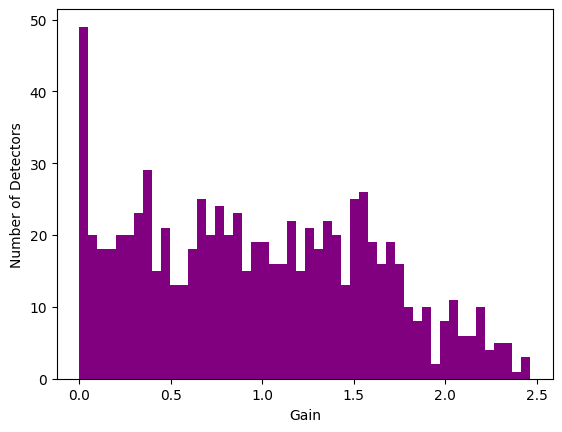

In [ ]:
qs = np.quantile(gain, [0.01, 0.95])
plt.figure()
plt.hist(gain, bins=np.linspace(qs[0],qs[1],51), color = 'purple');
plt.xlabel("Gain")
plt.ylabel("Number of Detectors")
plt.show()

This shows a large scatter in the detector gain, with 1st to 95th percentile around 0 and 2.5. Let's see the detectors with abnormally large gain fall in our tod fft power spectrum plot (shown in red).

In [ ]:
gain_sel = gain > 10

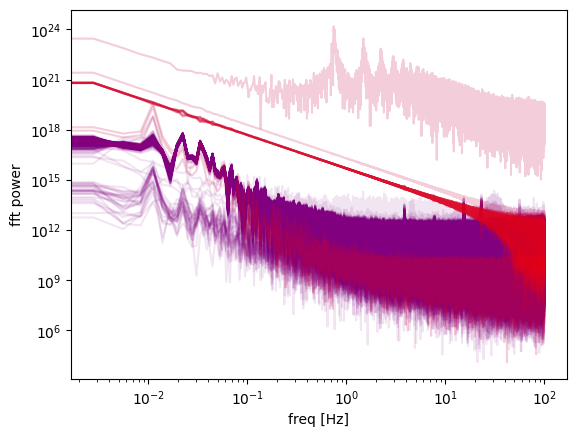

In [ ]:
plt.figure()
plt.loglog(freqs, ps[detsf90,:].T, alpha=0.1, c="purple")
plt.loglog(freqs, ps[detsf90[gain_sel],:].T, alpha=0.1, c="r")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

By filtering detectors with abnormal gains, we manage to flag detectors that show abnormal signal that doesn't follow the common mode!

This simple analysis shows the power of common-mode analysis, i.e., SVD in flagging weird detectors. To gain more insights to these detectors we can show where they are located in the detector array.

<ipython-input-21-5cb2912b619a>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(det_x, det_y, c='grey', vmin=0,vmax=1, s=100, cmap='Reds')
<ipython-input-21-5cb2912b619a>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(det_x[gain_sel], det_y[gain_sel], c='red', vmin=0,vmax=1, s=100, cmap='Reds')


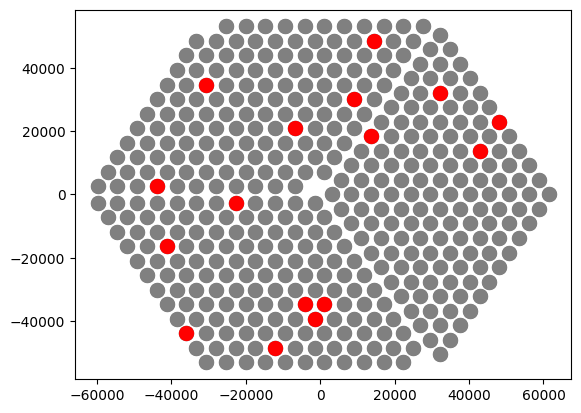

In [ ]:
det_x = tod.info.array_data['array_x'][detsf90]
det_y = tod.info.array_data['array_y'][detsf90]
plt.figure()
plt.scatter(det_x, det_y, c='grey', vmin=0,vmax=1, s=100, cmap='Reds')
plt.scatter(det_x[gain_sel], det_y[gain_sel], c='red', vmin=0,vmax=1, s=100, cmap='Reds')
plt.show()

This shows that many of these faulty detectors are clusterd or placed in a very regular way along a line, which may reflect the underlying instrumental effect.

Although filtering through `gain` to the common mode is particular fruitful for this TOD, it is often useful to calculate some other "pathological" parameters to inspect the health of a detector timestream.

### Other parameters

For example, we can compute the correlation matrix among the detectors. As we assume that the majority of the detectors are seeing the same atmosphere, we expect to see the majority of the detectors being highly correlated, while the faulty detectors emerge as poorly correlated.

In [ ]:
# Get correlation matrix
c = np.dot(lf_data,lf_data.T.conjugate())
a = np.linalg.norm(lf_data,axis=1)
aa = np.outer(a,a)
aa[aa==0.] = 1.
cc = c/aa

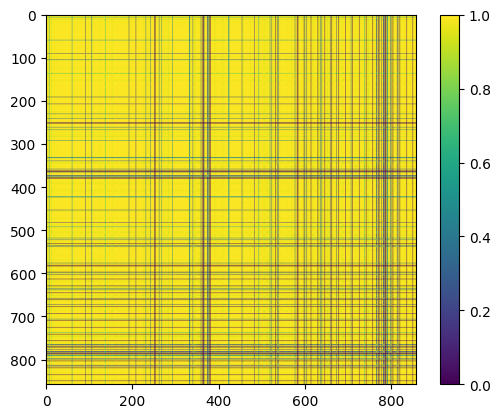

In [ ]:
plt.figure()
plt.imshow(np.abs(cc))
plt.colorbar()
plt.show()

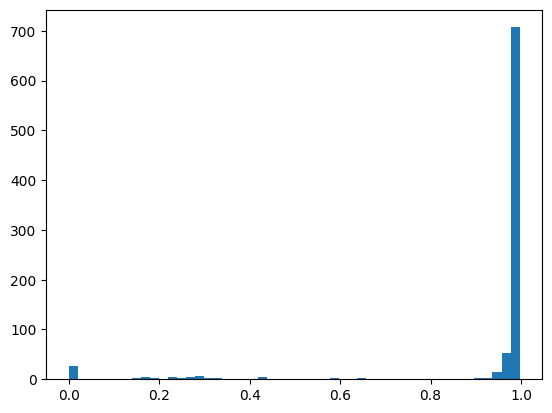

In [ ]:
plt.hist(np.median(np.abs(cc), axis=0), bins=50);

As expected, a majority of detectors are correlated with coefficient close to 1, while the subset of detectors that are poorly correlated is likely problematic and needs to be flagged. Alternatively, instead of calculating the full correlation matrix, we often like to evaluate how well each detector is correlated with the common mode, often denoted as `corr`, which measures the same effect. Similarly, another measures is the amplitude of the signal at the low frequency window which is often denoted as `norm`. Together, we use these three parameters to flag detectors with weird TOD fft spectra, as demonstrated for gain earlier.

In this example, we will simply flag detectors with a low median correlation below 0.8, which seems effective enough for this TOD.

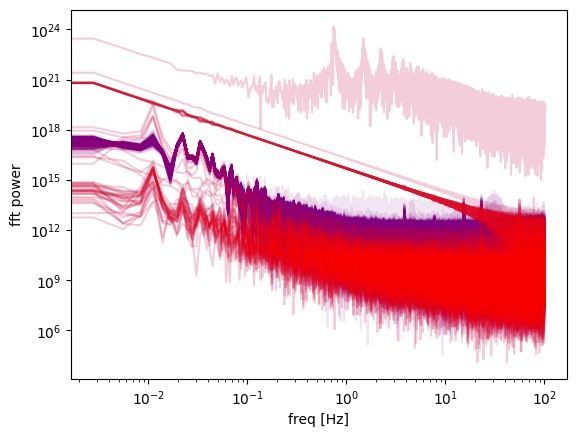

In [ ]:
corr_sel = np.median(np.abs(cc), axis=0) < 0.8

plt.figure()
plt.loglog(freqs, ps[detsf90,:].T, alpha=0.1, c="purple")
plt.loglog(freqs, ps[detsf90[corr_sel],:].T, alpha=0.1, c="r")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

This seems effective enough to flag a majority of detectors that deviate significantly from the common group. Now let's combine our flags.

In [ ]:
lf_sel = np.logical_or(gain_sel, corr_sel)

In [ ]:
del lf_data, cc

# High frequency

After assessing detector health in the low frequency part of the data which is atmosphere dominated, we also need to filter detectors with weird intrinsic noise properties. To evaluate that we need to focus on the high frequency part of the TOD spectra which is dominated by detector noise, instead of the atmosphere. For example, let's look at the remaining spectra after our low-frequency cut.

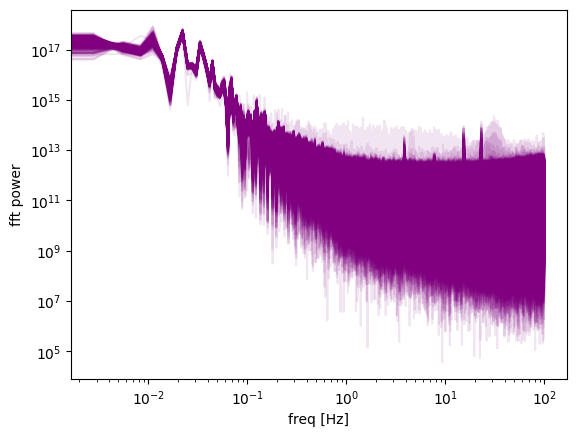

In [ ]:
plt.figure()
plt.loglog(freqs, ps[detsf90[~lf_sel],:].T, alpha=0.1, c="purple")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

This shows that we haven't done a perfect job in removing these faulty detectors. Let's hope they can be caught in our noise analysis. For noise analysis we focus on frequencies between 20 Hz and 100 Hz.

In [ ]:
fmask = (freqs>20)*(freqs<100)
hf_data = fdata[np.ix_(detsf90, fmask)]

The simpliest measure of detector noise property is the white noise level, or `rms`.  

In [ ]:
rms = np.sum(abs(hf_data)**2,axis=1)**0.5

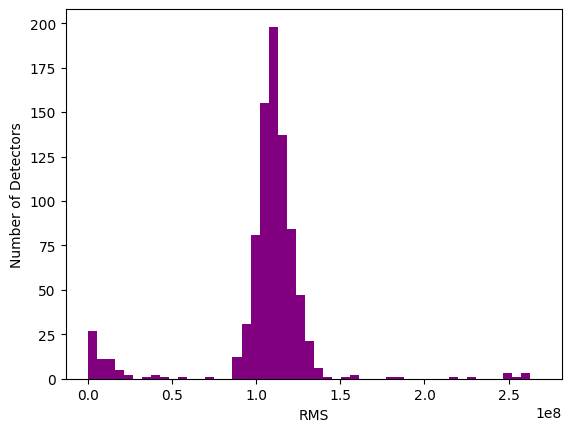

In [ ]:
qs = np.quantile(np.real(rms), [0.01, 0.99])
plt.figure()
plt.hist(rms, bins=np.linspace(qs[0],qs[1],51), color = 'purple');
plt.xlabel("RMS")
plt.ylabel("Number of Detectors")
plt.show()

It shows that the majority of our detectors have a similar white noise level but there are a small subset of detectors with alarmingly low noise level. In fact, having faulty detectors that appear to have a very low noise is very dangerous to CMB mapmaking because our mapmaker often weight our data by its inverse-variance. A apparent low-noise detector will have a very high weight and will have significant effect on the resulting CMB map. Hence it is important that we inspect carefully if they correspond to some faulty detectors.

In [ ]:
rms_sel = (rms<(0.5*1e8)) | (rms > 2e8)

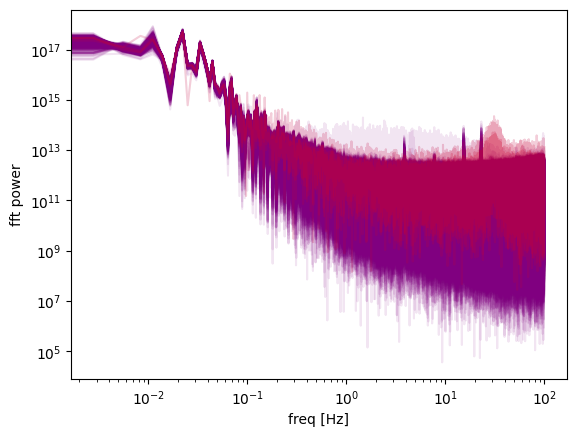

In [ ]:
plt.figure()
plt.loglog(freqs, ps[detsf90[~lf_sel],:].T, alpha=0.1, c="purple")
plt.loglog(freqs, ps[detsf90[rms_sel * (~lf_sel)],:].T, alpha=0.1, c="r")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

It shows that the rms cut also manages to catch a group of detectors that feature a bump in their spectra near 100 GHz.

In addition to rms, we often also calculate some higher order statistical noise properties including kurtosis and skewness. They are similarly used to find weirdly behaving detectors. Since `rms` seems to be quite effective in this example, we will omit the rest.

# 2. Detector cuts

A final detector cut is a obtained by merging different criteria we placed on each of the "pathological" parameters we calculate, such as `gain`, `corr`, `rms`, etc. For our case, as we only calculated the `gain` and `rms`, we will merge them to obtain the final detector cut.

In [ ]:
det_cuts = np.logical_or(lf_sel, rms_sel)

print("low-freq cut: ", np.sum(lf_sel))
print("rms + low-freq cut: ", np.sum(det_cuts))

low-freq cut:  78
rms + low-freq cut:  82


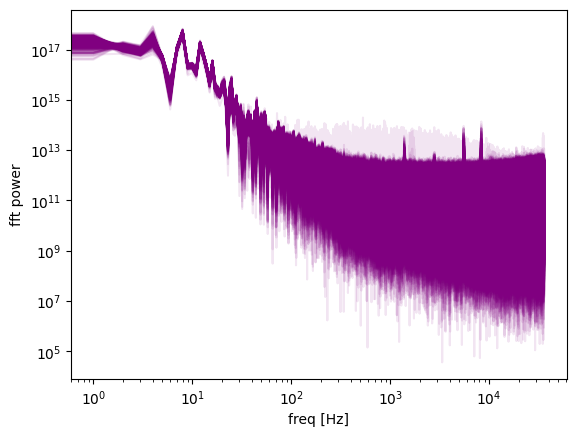

In [ ]:
plt.figure()
plt.loglog(ps[detsf90[~det_cuts],:].T, alpha=0.1, c="purple")
plt.xlabel("freq [Hz]")
plt.ylabel("fft power")
plt.show()

This shows what we are able to achieve with our simple detector cuts. Despite not being perfect, we managed to get rid of a lot of abnormal detectors in our TOD. ACT detector cuts follow the same philosophy as this except the criteria used to produce detector cuts reply on 8 parameters instead of 3 we showed here. The thresholds are placed by inspecting histogram across each observational year. This simple detector cuts algorithm has been quite effective in ACT. For full list of parameters used, please refer to Appendix A in Naess et al. 2025.